In [72]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Input, Dropout, Flatten, Lambda
from tensorflow.keras.applications import EfficientNetB6, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import Callback

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(f'train_instaces: {len(X_train)} and test_instances: {len(X_test)}')
print(np.unique(y_train))

train_instaces: 60000 and test_instances: 10000
[0 1 2 3 4 5 6 7 8 9]


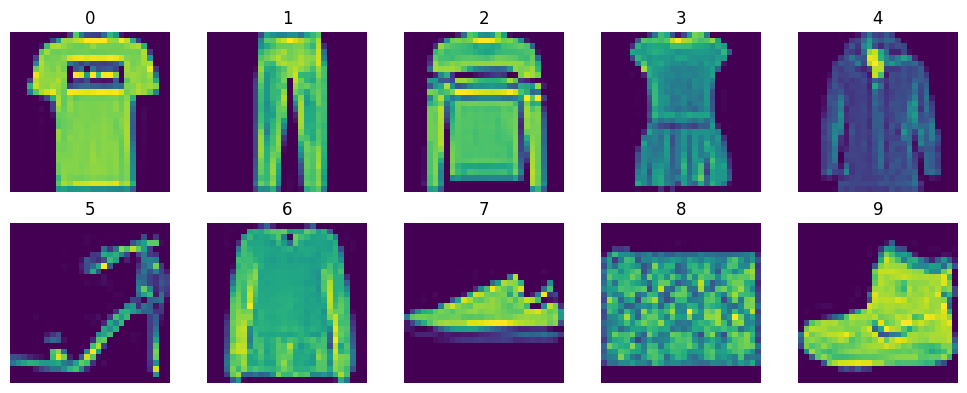

In [6]:
fig, axs = plt.subplots(2, 5, figsize = (10, 4))
ax = axs.ravel()
for i in range(10):
    ax[i].imshow(X_train[np.where(y_train == i)[0][0]])
    ax[i].axis('off')
    ax[i].set_title(i)

plt.tight_layout()
plt.show()

In [7]:
X_train = X_train / 255
X_test = X_test / 255

In [8]:
X_valid = X_train[:5000]
y_valid = y_train[:5000]

X_train = X_train[5000:]
y_train = y_train[5000:]

In [9]:
X_train[0].shape

(28, 28)

In [34]:
def cov_model():
    input_layer = Input((28, 28, 1))
    x = Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(input_layer)
    x = MaxPool2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(x)
    x = MaxPool2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(x)
    x = MaxPool2D(pool_size = (2, 2))(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dense(128, activation = 'relu')(x)
    output_layer = Dense(10, activation = 'sigmoid')(x)
    return tf.keras.Model(input_layer, output_layer)

In [35]:
class Epochs(Callback):
    def __init__(self, epoch):
        super().__init__()
        self.epoch = epoch
    def on_epoch_end(self, epo, logs = None):
        if (epo + 1) % self.epoch == 0:
            print(f"loss: {logs['loss']:.6f} - val_loss: {logs.get('val_loss', 'N/A'):.6f}")


def run_model(X, y, X_val, y_val, epo = 5):
    aug_train = ImageDataGenerator(
        horizontal_flip = True,
        rotation_range = 45,
        vertical_flip = True,
        zoom_range = [1, 1.5],
        height_shift_range = 0.1,
        width_shift_range = 0.1)
    
    X = np.expand_dims(X, axis = -1)
    data = aug_train.flow(X, y = y)

    model = cov_model()
    model.compile(optimizer = SGD(), loss = sparse_categorical_crossentropy)
    history = model.fit(data, epochs = epo, validation_data = (X_val, y_val), verbose = 0, callbacks = [Epochs(10)])

    plt.figure()
    plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'], label = 'act')
    plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['val_loss'], label = 'val')
    plt.legend()
    plt.show()
    
    return model, model.get_weights()

model_1, model_weights = run_model(X_train.copy(), y_train, X_valid, y_valid, 40)

In [42]:
(np.argmax(model_1.predict(X_test, verbose = 0), axis = 1) == y_test).sum() / len(y_test)

0.7832

In [ ]:
def tl_cov(X, y):
    aug_train = ImageDataGenerator(
        horizontal_flip = True,
        rotation_range = 45,
        vertical_flip = True,
        zoom_range = [1, 1.5],
        height_shift_range = 0.1,
        width_shift_range = 0.1)
    
    X = np.expand_dims(X, axis = -1)
    data = aug_train.flow(X, y = y)
    model = cov_model()
    model.compile(optimizer = SGD(), loss = sparse_categorical_crossentropy)
    history = model.fit(data, epochs = epo, validation_data = (X_val, y_val), verbose = 0, callbacks = [Epochs(10)])


In [85]:
def tl_cov(learn = False):
    input_layer = Input((28, 28, 3))
    x = tf.keras.layers.Resizing(48, 48)(input_layer)
    pre_mdl = VGG16(include_top = False, input_tensor = x, pooling = 'avg')
    pre_mdl.trainable = False
    pre_mdl.layers[-1].trainable = True
    if learn is True:
        for layer in pre_mdl.layers[-10:]:
            layer.trainable = True
    fin_layer = pre_mdl.output
    x = Flatten()(fin_layer)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    output_layer = Dense(10, activation = 'sigmoid')(x)
    return tf.keras.Model(input_layer, output_layer)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 286ms/step - loss: 1.8216 - val_loss: 1.1752
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 292ms/step - loss: 1.1861 - val_loss: 1.0396
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 292ms/step - loss: 1.0610 - val_loss: 0.9393
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 293ms/step - loss: 1.0069 - val_loss: 0.9458
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 295ms/step - loss: 0.9706 - val_loss: 0.8802
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - loss: 0.9567 - val_loss: 0.8560
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 312ms/step - loss: 0.9167 - val_loss: 0.8730
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 106s 338ms/step - loss: 0.9046 - val_loss: 0.8388
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 336ms/step - loss: 0.8654 - val_loss: 0.8291
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.8694loss: 0.866370 - val_loss: 0.857478
313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 320ms/step - loss: 0.8694 - val_loss: 0.8575
Epoch 11/15
3

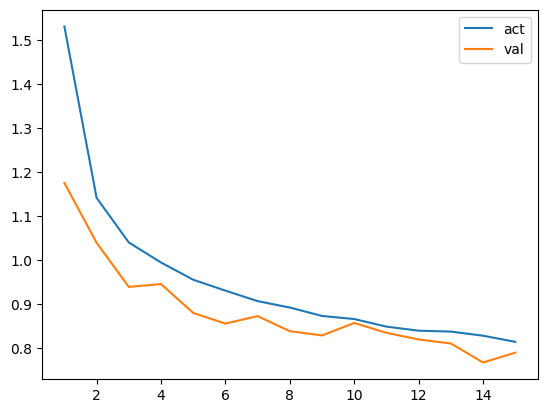

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 152s 483ms/step - loss: 1.5389 - val_loss: 0.7896
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 153s 488ms/step - loss: 0.8049 - val_loss: 0.6847
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 483ms/step - loss: 0.7255 - val_loss: 0.5894
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 478ms/step - loss: 0.6623 - val_loss: 0.5951
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 455ms/step - loss: 0.6185 - val_loss: 0.6175
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 460ms/step - loss: 0.6074 - val_loss: 0.5181
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 475ms/step - loss: 0.5777 - val_loss: 0.5368
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 457ms/step - loss: 0.5424 - val_loss: 0.6265
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 459ms/step - loss: 0.5209 - val_loss: 0.4896
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.5186loss: 0.513449 - val_loss: 0.479821
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 457ms/step - loss: 0.5186 - val_loss: 0.4798
Epoch 

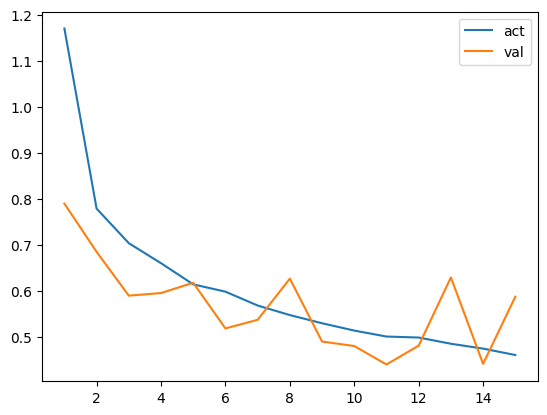

In [87]:
def show_im(history):
    plt.figure()
    plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'], label = 'act')
    plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['val_loss'], label = 'val')
    plt.legend()
    plt.show()

def tl_run(X, y, X_val, y_val, epo = 5, weights = None, trainable = False):
    aug_train = ImageDataGenerator(
        horizontal_flip = True,
        rotation_range = 45,
        vertical_flip = True,
        height_shift_range = 0.1,
        width_shift_range = 0.1)
    
    data = aug_train.flow(X, y = y)

    if trainable is False:
        model = tl_cov(learn = True)
        model.set_weights(weights)
        model.compile(optimizer = SGD(), loss = sparse_categorical_crossentropy)
        history = model.fit(data, epochs = epo, validation_data = (X_val, y_val), verbose = 1, callbacks = [Epochs(10)])
        show_im(history)
    else:
        model = tl_cov()
        model.compile(optimizer = SGD(), loss = sparse_categorical_crossentropy)
        history = model.fit(data, epochs = epo, validation_data = (X_val, y_val), verbose = 1, callbacks = [Epochs(10)])
        show_im(history)
        if trainable is True:
            tl_run(X, y, X_val, y_val, epo = 15, weights = model.get_weights(), trainable = False)
    
    return model

model_2 = tl_run(np.dstack([X_train.copy()[:10000]] * 3).reshape(-1, 28, 28, 3), y_train[:10000], np.dstack([X_valid.copy()] * 3).reshape(-1, 28, 28, 3), y_valid, 15, trainable = True)

In [91]:
(np.argmax(model_2.predict(np.dstack([X_test.copy()] * 3).reshape(-1, 28, 28, 3), verbose = 0), axis = 1) == y_test).sum() / len(y_test)

0.6992